In [7]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import random
import csv

In [2]:
def print_solution1(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            location_coord = data['locations'][node_index]
            plan_output += ' ({},{}) -> '.format(location_coord[0], location_coord[1])
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))


In [3]:
def generate_data_model(grid_size, num_locations, num_vehicles,init_depot):
    """Generates the data for the problem with a grid and randomly placed locations."""
    data = {}
    
    # Generate the grid
    grid = [(x, y) for x in range(grid_size) for y in range(grid_size)]
    
    # Randomly select locations from the grid
    locations = init_depot + random.sample(grid, num_locations-1)
    
    # Calculate distances between locations
    distance_matrix = []
    for i in range(num_locations):
        row = []
        for j in range(num_locations):
            if i == j:
                row.append(0)
            else:
                dist = abs(locations[i][0] - locations[j][0]) + abs(locations[i][1] - locations[j][1])
                row.append(dist)
        distance_matrix.append(row)
    
    data['locations'] = locations
    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = num_vehicles
    data['depot'] = 0  # Assuming the depot is located at index 0
    
    return data

In [4]:
def initialize(data):
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                            data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        5000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    return routing,manager

In [5]:
def convert_to_initial_solution(solution, manager, routing, data):
    initial_routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            if node_index != 0:
                route.append(data['locations'][node_index])
            index = solution.Value(routing.NextVar(index))
        initial_routes.append(route)
    return initial_routes

In [72]:
# Instantiate the data problem.
grid_size=100
random_locations=50
num_vehicles=5
init_depot = [(50,50)]

data = generate_data_model(grid_size,random_locations,num_vehicles,init_depot)

In [73]:
routing,manager = initialize(data)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 100  # Set a time limit for the solver.

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [102]:
# Print solution on console.
if solution:
    print_solution1(data, manager, routing, solution)
else:
    print('No solution found!')
    
convert_solution = convert_to_initial_solution(solution, manager, routing,data)
print(convert_solution)

Objective: 100866
Route for vehicle 0:
 (250,250) ->  (280,353) ->  (324,462) ->  (347,470) ->  (347,431) ->  (420,429) ->  (457,351) ->  (425,305) ->  (359,335) ->  (295,336) -> Distance of the route: 916m

Route for vehicle 1:
 (250,250) ->  (302,200) ->  (328,172) ->  (361,159) ->  (395,82) ->  (457,0) ->  (383,8) ->  (385,23) ->  (270,29) ->  (236,98) ->  (228,145) ->  (231,213) -> Distance of the route: 962m

Route for vehicle 2:
 (250,250) ->  (210,198) ->  (179,169) ->  (163,168) ->  (152,144) ->  (121,102) ->  (102,69) ->  (71,48) ->  (24,19) ->  (43,37) ->  (45,218) ->  (81,248) ->  (147,232) -> Distance of the route: 946m

Route for vehicle 3:
 (250,250) ->  (250,291) ->  (183,358) ->  (180,446) ->  (137,479) ->  (144,358) ->  (47,351) ->  (45,340) ->  (96,274) ->  (124,267) -> Distance of the route: 882m

Route for vehicle 4:
 (250,250) ->  (296,231) ->  (451,161) ->  (456,130) ->  (459,51) ->  (486,13) ->  (491,26) ->  (493,26) ->  (473,152) -> Distance of the route: 960m



## Visualize routes solutions

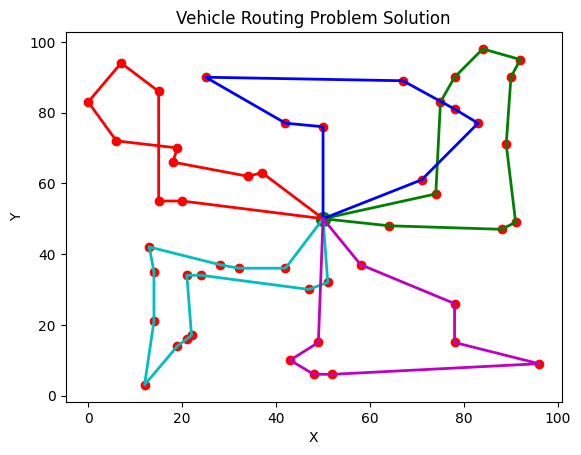

In [9]:
import matplotlib.pyplot as plt

def draw_solution(data, manager, routing, solution):
    """Draws the solution on a graph with color-coded routes for each vehicle."""
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create a list of colors for each vehicle
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Plot the nodes
    for node in range(manager.GetNumberOfNodes()):
        if node == data['depot']:
            ax.plot(data['locations'][node][0], data['locations'][node][1], 'go', markersize=10)  # Depot
        else:
            ax.plot(data['locations'][node][0], data['locations'][node][1], 'ro')  # Customers

    # Plot the routes for each vehicle
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route_x = [data['locations'][manager.IndexToNode(index)][0]]
        route_y = [data['locations'][manager.IndexToNode(index)][1]]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route_x.append(data['locations'][manager.IndexToNode(index)][0])
            route_y.append(data['locations'][manager.IndexToNode(index)][1])
        # Get the color for the current vehicle
        color = colors[vehicle_id % len(colors)]
        # Plot the route with the color for the current vehicle
        ax.plot(route_x, route_y, color=color, linewidth=2)

    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Vehicle Routing Problem Solution')

    # Show the plot
    plt.show()

# Example usage
draw_solution(data, manager, routing, solution)

## Automate the process

In [8]:
nbr_iterations = 10

# Instantiate the data problem.
grid_size=100
random_locations=50
num_vehicles=5
init_depot = [(50,50)]

time_limit = 100

file_path = 'data\\'
file_name='test'

# Create columns in file
with open((file_path+file_name), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)    
    writer.writerow(['x1', 'x2','v'])

    for i in range(nbr_iterations):
        print('Iteration',i)
        
        # Generate data and initialize CP solver
        data = generate_data_model(grid_size,random_locations,num_vehicles,init_depot)
        routing,manager = initialize(data)

        # Setting heuristics
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        search_parameters.time_limit.seconds = time_limit  # Set a time limit for the solver.

        # Solve the problem
        solution = routing.SolveWithParameters(search_parameters)
        convert_solution = convert_to_initial_solution(solution, manager, routing,data)
        
        # Save solution
        locations = data['locations']
        for i,vehicle_route in enumerate(convert_solution):
            for coord in vehicle_route:
                writer.writerow([coord[0], coord[1], i])
        writer.writerow([])  # Add a line space


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
